# Problem Statement

## Glomeruli Segmentation
> Dataset Source https://www.kaggle.com/c/hubmap-kidney-segmentation

> Here the challenge is to detect functional tissue units (FTUs) across different tissue preparation pipelines. An FTU is defined as a “three-dimensional block of cells centered around a capillary, such that each cell in this block is within diffusion distance from any other cell in the same block” (de Bono, 2013). The goal of this competition is the implementation of a successful and robust glomeruli FTU detector.


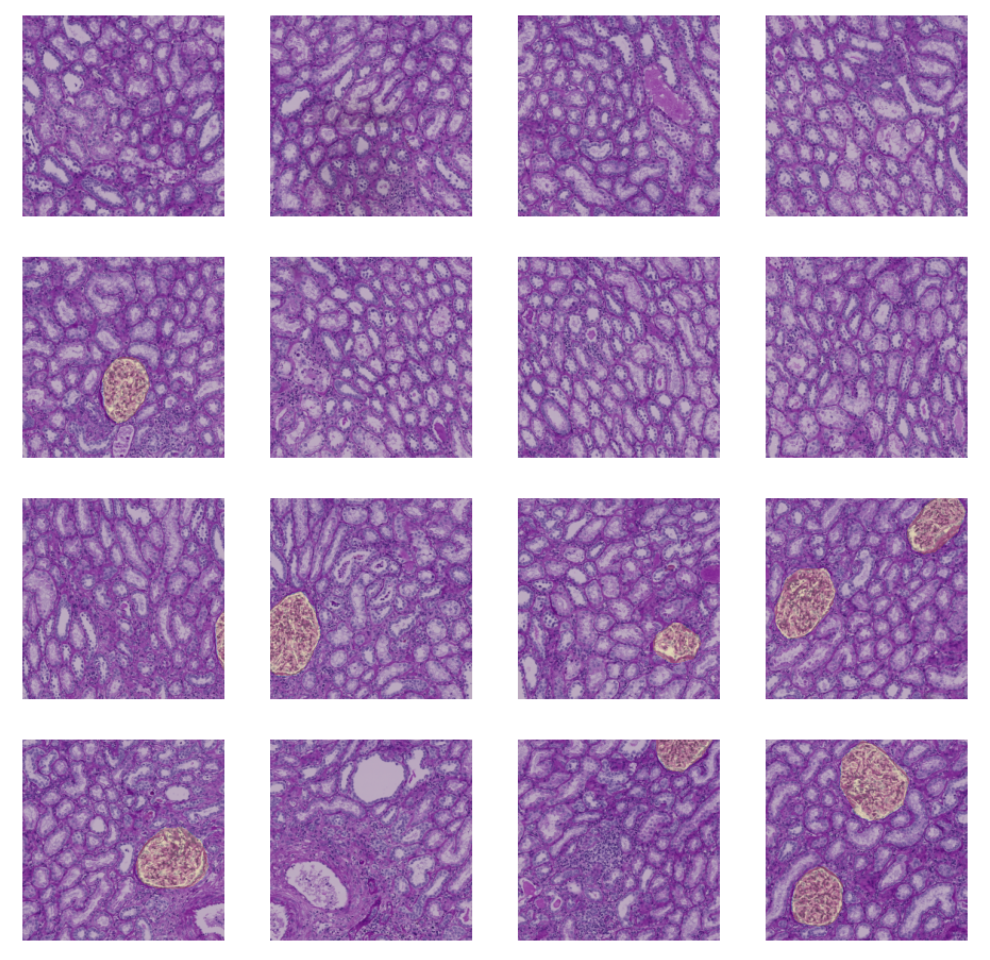

# House Keeping

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

In [2]:
import sys
import tensorflow as tf
import tensorflow.keras.backend as K
import random
import os
import numpy as np
import cv2
import pandas as pd
import json
import gc
import os

from sklearn.model_selection import GroupKFold
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam, Nadam

import matplotlib.pyplot as plt

root_path = 'gdrive/MyDrive/Colab Notebooks/RISING2021'
os.chdir(root_path)
cwd_path = os.getcwd()
root_path = os.getcwd()

train_path = os.path.join(cwd_path,'data/256x256')
history_path = os.path.join(cwd_path,'history/history.json')
model_path   = os.path.join(cwd_path,'model/model.h5')

print(train_path)
print(root_path)
print(history_path)
print(model_path)

/content/gdrive/MyDrive/Colab Notebooks/RISING2021/data/256x256
/content/gdrive/MyDrive/Colab Notebooks/RISING2021
/content/gdrive/MyDrive/Colab Notebooks/RISING2021/history/history.json
/content/gdrive/MyDrive/Colab Notebooks/RISING2021/model/model.h5


# Data Processing


In [3]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, IMG_SIZE = 256):
        'Initialization'
        self.dim_image  = (IMG_SIZE,IMG_SIZE,3)
        self.dim_mask   = (IMG_SIZE,IMG_SIZE,1)
        self.batch_size = 16
        self.list_IDs   = list_IDs
        self.n_classes  = 1
        self.shuffle    = True
        self.IMG_SIZE   = IMG_SIZE
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size,*self.dim_image),dtype=float)
        Y = np.empty((self.batch_size,*self.dim_mask), dtype=float)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Load The Image
            filename_img = train_path + "/train/" + ID
            #print("Input Image File Name : " + str(filename_img))
            img = cv2.imread(filename_img)
            #img = np.clip(img - np.median(img)+127, 0, 255)
            #img = img/255.0
            X[i,:,:,:] = img.astype(np.float32)
            
            # Load the Mask
            filename_mask = train_path + "/masks/" + ID
            #print("Input Mask File Name : " + str(filename_mask))
            mask = cv2.imread(filename_mask,0)
            #mask = mask/255.0
            Y[i,:,:,0] = mask.astype(np.float32)
            
        return X, Y

# U-Net Architecture Survey (Theory)



## Vanilla U-Net
> Ref : https://arxiv.org/abs/1505.04597

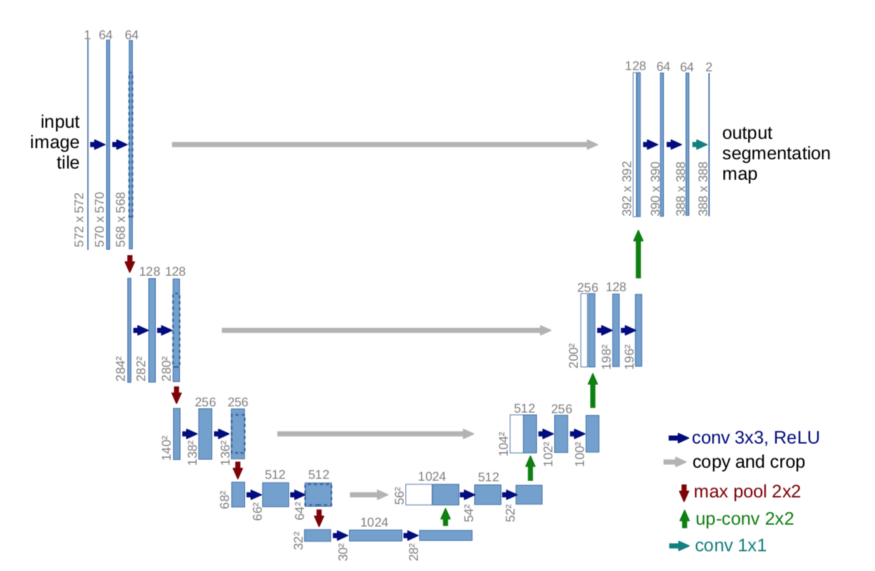

## UNet Variants
> Ref : https://arxiv.org/ftp/arxiv/papers/2004/2004.08790.pdf
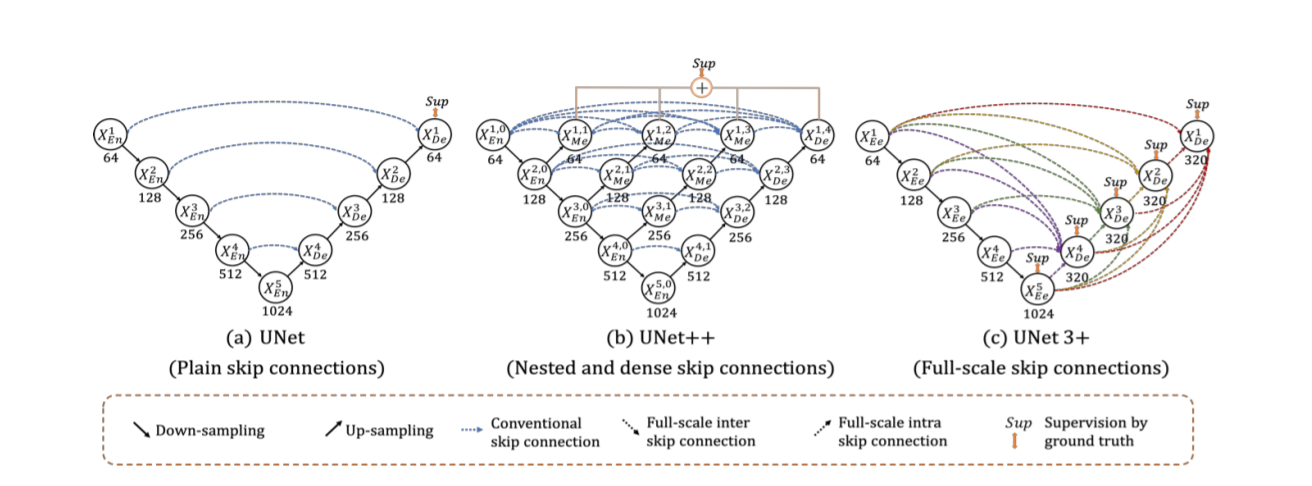

## Double U-Net architecture
> Ref : https://arxiv.org/pdf/2006.04868.pdf
> 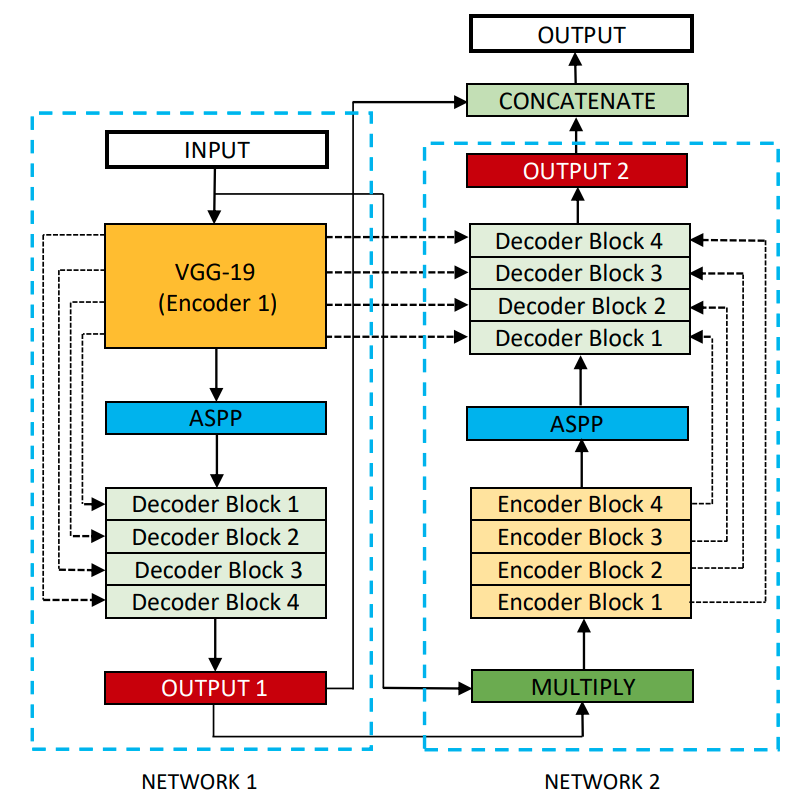

### ASPP
> Ref : https://arxiv.org/abs/1606.00915v2
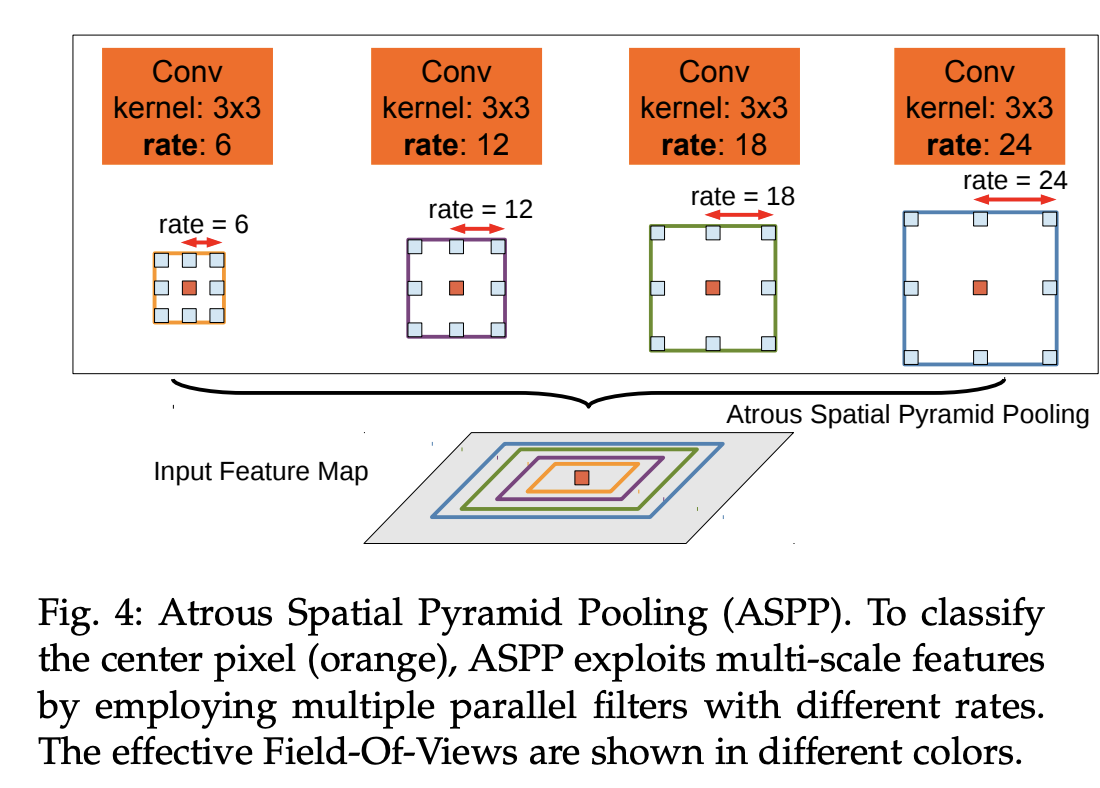

# Double UNet Implementation

## Architecture Blocks

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.applications import *

def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    #outputs = Concatenate()([outputs1, outputs2])
    #combine_output = Conv2D(1, (64, 64), activation="sigmoid", padding="same")(outputs)
    model = Model(inputs, outputs2)
    return model

##################################################################################################################################################################################################
#model = build_model((256,256,3))
#model.summary(line_length=150)

## Loss Functions


> 1. Binary Cross Entropy
The Binary cross entropy loss evaluates the class predictions for each pixel vector individually and then averages over all pixels
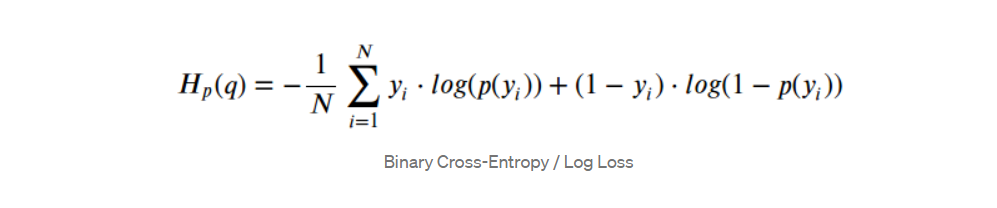

> 2. Dice Coefficient
Dice coefficient is essentially a measure of overlap between two samples of two sets A & B. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap
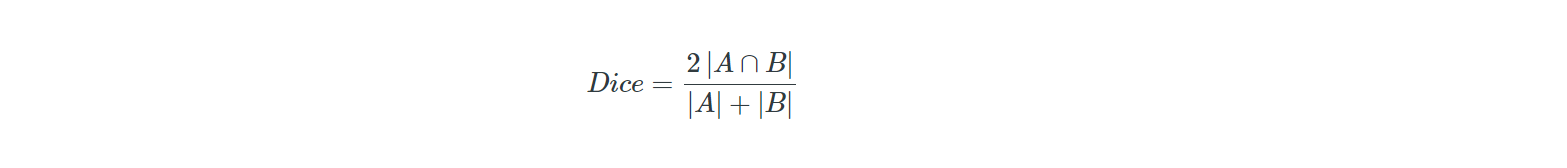

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

## Get Data

In [7]:
def get_train_validation_list():
    PATH_TRAIN_IMAGES = train_path + "/train/" 
    list_images = os.listdir(PATH_TRAIN_IMAGES)
    random.shuffle(list_images)
    split_factor = 0.75
    list_train = list_images[:int(split_factor * len(list_images))]
    list_valid = list_images[int(split_factor * len(list_images)) : ]
    print("Length of Training Set Images : " + str(len(list_train)))
    print("Length of Validation Set Images : " + str(len(list_valid)))
    return list_train,list_valid
    
def check_samples(generator):
    X,Y = generator.__getitem__(0)
    print("#####################################")
    print(Y[0,:,:,0].shape)
    print("#####################################")
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(np.asarray(X[0],dtype=np.uint8))
    axarr[1].imshow(np.asarray(Y[0,:,:,0],dtype=np.uint8))   

## Main

In [8]:
def main():
        list_train,list_valid = get_train_validation_list()
        training_generator    = DataGenerator(list_train)
        validation_generator  = DataGenerator(list_valid)
        model = build_model((256,256,3))
                
        metrics = [
            dice_coef,
            iou,
            Recall(),
            Precision()
        ]
        lr = 1e-3
        model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)
        
        callbacks = [
        ModelCheckpoint(model_path),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
        ]
        
        # fit model
        history = model.fit_generator(generator=training_generator,validation_data=validation_generator,verbose=1,epochs=2,callbacks=callbacks)
        
        #write the history
        filename_history = history_path
        hist_df = pd.DataFrame(history.history)         
        with open(filename_history, mode='w') as f:
            hist_df.to_json(f)
    
        df = pd.read_json(filename_history)
        print(df)

main()

Length of Training Set Images : 2757
Length of Validation Set Images : 919


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
172/172 [==============================] - 133s 693ms/step - loss: 0.8351 - dice_coef: 0.1649 - iou: 0.0938 - recall: 0.7922 - precision: 0.1063 - val_loss: 0.9274 - val_dice_coef: 0.0726 - val_iou: 0.0379 - val_recall: 0.2755 - val_precision: 0.0560
Epoch 2/2
172/172 [==============================] - 110s 636ms/step - loss: 0.3763 - dice_coef: 0.6237 - iou: 0.4625 - recall: 0.6831 - precision: 0.6727 - val_loss: 0.3496 - val_dice_coef: 0.6504 - val_iou: 0.4897 - val_recall: 0.6656 - val_precision: 0.7087
       loss  dice_coef       iou  ...  val_recall  val_precision     lr
0  0.719945   0.280055  0.176095  ...    0.275515       0.056041  0.001
1  0.349687   0.650313  0.492265  ...    0.665643       0.708677  0.001

[2 rows x 11 columns]


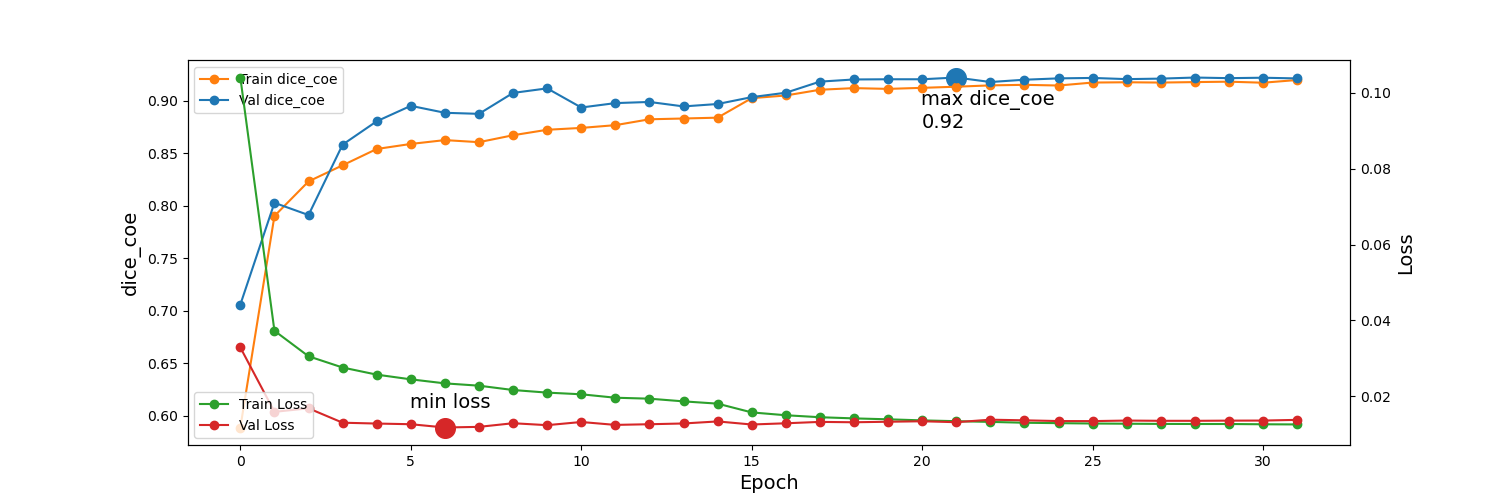

## Predictions

Length of Training Set Images : 2757
Length of Validation Set Images : 919
#####################################
(256, 256)
#####################################


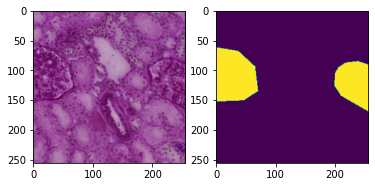

In [17]:
list_train,list_valid = get_train_validation_list()
training_generator    = DataGenerator(list_train)
validation_generator  = DataGenerator(list_valid)
check_samples(training_generator)

In [1]:
list_train,list_valid = get_train_validation_list()
training_generator    = DataGenerator(list_train)
validation_generator  = DataGenerator(list_valid)
check_samples(training_generator)

NameError: ignored